# Anomaly Detection

Anomaly detection is used to detect... you guessed it: anomalies. So what are the use cases of detecting anomalies? Well, there are some clear ones with fraud detection, cybersecurity, and video surveillance. Another great one is *data preprocessing*. Remember when we did Linear Regression and two outliers caused our "best-fit" line to deviate a substantial amount? With data preprocessing, we can train a model to look through our data and find data points that are not similar to the majority of the rest of the data. This is *extremely* useful when training new models.

## The Dataset

Let's jump right into the dataset. It was downloaded from [Hugging Face](https://huggingface.co/datasets/vitaliy-sharandin/climate-global-temp-anomaly) and contains data about the yearly measurements of ocean temperature in different regions of the world.

In [1]:
#| echo: false

import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('temperature.csv', encoding='windows-1252')
df.head()

,Entity,Code,Year,Global average temperature anomaly relative to 1961-1990,Upper bound (95% confidence interval) of the annual temperature anomaly,Lower bound (95% confidence interval) of the annual temperature anomaly
0,Global,NaN,1850,-0.417659,-0.246115,-0.589203
1,Global,NaN,1851,-0.233350,-0.054832,-0.411868
2,Global,NaN,1852,-0.229399,-0.049416,-0.409382
3,Global,NaN,1853,-0.270354,-0.110700,-0.430009
4,Global,NaN,1854,-0.291630,-0.150436,-0.432824


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 6 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Entity                                                                   519 non-null    object 
 1   Code                                                                     0 non-null      float64
 2   Year                                                                     519 non-null    int64  
 3   Global average temperature anomaly relative to 1961-1990                 519 non-null    float64
 4   Upper bound (95% confidence interval) of the annual temperature anomaly  519 non-null    float64
 5   Lower bound (95% confidence interval) of the annual temperature anomaly  519 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 24.5+ KB


In [50]:
df['Entity'].value_counts()

Entity
Global                 173
Northern Hemisphere    173
Southern Hemisphere    173
Name: count, dtype: int64

Let's do a little exploring first:

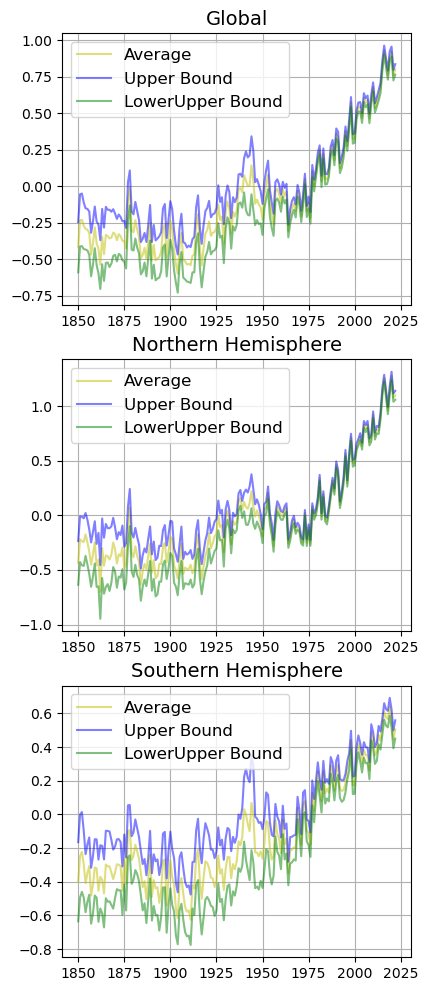

In [116]:
#| fig-align: center

X = df['Year']
upper = df['Upper bound (95% confidence interval) of the annual temperature anomaly']
lower = df['Lower bound (95% confidence interval) of the annual temperature anomaly']
average = df['Global average temperature anomaly relative to 1961-1990']

plt.figure(figsize=(4.5, 12))
plt.subplot(311)
plt.plot(X[df['Entity'] == "Global"], average[df['Entity'] == "Global"], "y", label="Average", alpha=0.5)
plt.plot(X[df['Entity'] == "Global"], upper[df['Entity'] == "Global"], "b", label="Upper Bound", alpha=0.5)
plt.plot(X[df['Entity'] == "Global"], lower[df['Entity'] == "Global"], "g", label="LowerUpper Bound", alpha=0.5)
plt.title('Global')
plt.legend()
plt.grid()
plt.subplot(312)
plt.plot(X[df['Entity'] == "Northern Hemisphere"], average[df['Entity'] == "Northern Hemisphere"], "y", label="Average", alpha=0.5)
plt.plot(X[df['Entity'] == "Northern Hemisphere"], upper[df['Entity'] == "Northern Hemisphere"], "b", label="Upper Bound", alpha=0.5)
plt.plot(X[df['Entity'] == "Northern Hemisphere"], lower[df['Entity'] == "Northern Hemisphere"], "g", label="LowerUpper Bound", alpha=0.5)
plt.title('Northern Hemisphere')
plt.legend()
plt.grid()
plt.subplot(313)
plt.plot(X[df['Entity'] == "Southern Hemisphere"], average[df['Entity'] == "Southern Hemisphere"], "y", label="Average", alpha=0.5)
plt.plot(X[df['Entity'] == "Southern Hemisphere"], upper[df['Entity'] == "Southern Hemisphere"], "b", label="Upper Bound", alpha=0.5)
plt.plot(X[df['Entity'] == "Southern Hemisphere"], lower[df['Entity'] == "Southern Hemisphere"], "g", label="LowerUpper Bound", alpha=0.5)
plt.title('Southern Hemisphere')
plt.grid()
plt.legend()
plt.show()

We can see obvious trends, but it is clear that there are some extremely large jumps and dips for certain years. It definitely seems like the Southern Hemisphere has the most action. Let's plot the upper bound versus the lower bound this time:

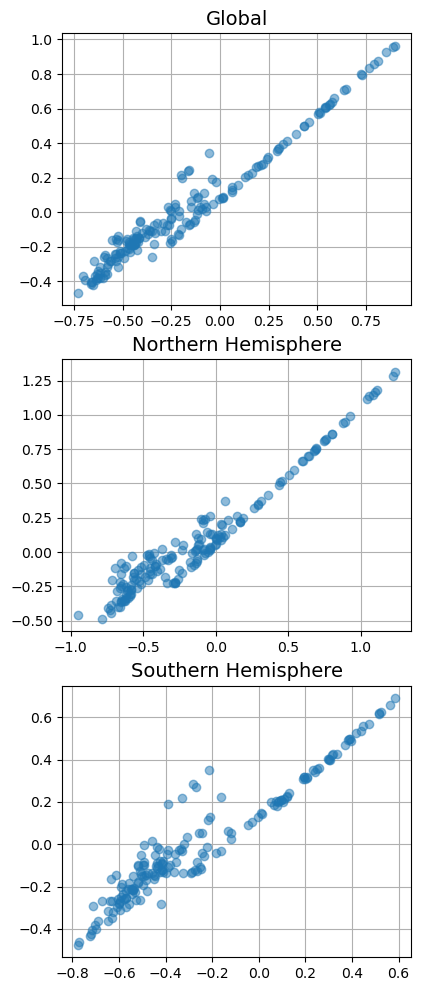

In [117]:
#| fig-align: center

X = df['Lower bound (95% confidence interval) of the annual temperature anomaly']
y = df['Upper bound (95% confidence interval) of the annual temperature anomaly']

plt.figure(figsize=(4.5, 12))
plt.subplot(311)
plt.plot(X[df['Entity'] == "Global"], y[df['Entity'] == "Global"], "o", alpha=0.5)
plt.title('Global')
plt.grid()
plt.subplot(312)
plt.plot(X[df['Entity'] == "Northern Hemisphere"], y[df['Entity'] == "Northern Hemisphere"], "o", alpha=0.5)
plt.title('Northern Hemisphere')
plt.grid()
plt.subplot(313)
plt.plot(X[df['Entity'] == "Southern Hemisphere"], y[df['Entity'] == "Southern Hemisphere"], "o", alpha=0.5)
plt.title('Southern Hemisphere')
plt.grid()
plt.show()

Sure enough, the Southern Hemisphere seems to have quite a few years where the upper and lower bounds are wildly different from what they usually are. Let's use DBSCAN to see if we can find clusters and anomalies:

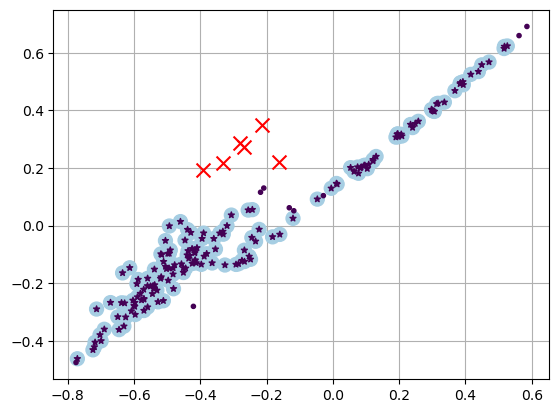

In [114]:
#| fig-align: center

from sklearn.cluster import DBSCAN
import numpy as np

X = np.empty((173, 2))
X1 = df['Lower bound (95% confidence interval) of the annual temperature anomaly']
X2 = df['Upper bound (95% confidence interval) of the annual temperature anomaly']
X[:, 0] = X1[df['Entity'] == "Southern Hemisphere"]
X[:, 1] = X2[df['Entity'] == "Southern Hemisphere"]

dbscan = DBSCAN(eps=0.1, min_samples=6)
dbscan.fit(X)

def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    plt.grid()
    plt.gca().set_axisbelow(True)

plot_dbscan(dbscan, X, size=100)
plt.show()

And there we have it! We were easily able to classify the most obviously out-of-place data points as anomalies using DBSCAN. At this point, the data scientist could remove the corresponding data to keep any trained models accurate, or leave it in and inform users of the data set that these exist.